In [16]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from mstamp_stamp import mstamp
from mstamp_RMSEs import compute_mstamp_RMSEs
from bits_compression import MDL
from demo import plot_motifs

In [5]:
def plot_motifs(matrix_profile, data, sub_len, dimensionality=None):
    motif_at = matrix_profile[dimensionality - 1, :].argsort()[:2]

    plt.figure(figsize=(20, 10))
    for i in range(data.shape[1]):
        plt.subplot(data.shape[1] + 1, 1, i + 1)
        plt.plot(data.T[i, :])
        plt.title('$T_{}$'.format(i + 1))
        for m in motif_at:
            plt.plot(range(m, m + sub_len), data.T[i, :][m:m + sub_len], c='r')
        plt.xlim((0, matrix_profile.shape[1]))

    plt.subplot(data.shape[1] + 1, 1, data.shape[1] + 1)
    plt.title('{}-dimensional Matrix Profile'.format(dimensionality))
    plt.plot(matrix_profile[dimensionality - 1, :])
    for m in motif_at:
        plt.axvline(m, c='r')
    plt.xlim((0, matrix_profile.shape[1]))
    plt.tight_layout()


In [6]:
data = pd.read_excel("data_akbilgic.xlsx")

/Users/adrien/opt/miniconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [7]:
data

,Unnamed: 0,TL BASED,USD BASED,imkb_x,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,date,ISE,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
1,2009-01-05 00:00:00,0.035754,0.038376,-0.004679,0.002193,0.003894,0,0.03119,0.012698,0.028524
2,2009-01-06 00:00:00,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.01892,0.011341,0.008773
3,2009-01-07 00:00:00,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
4,2009-01-08 00:00:00,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
...,...,...,...,...,...,...,...,...,...,...
532,2011-02-16 00:00:00,0.008599,0.0134,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
533,2011-02-17 00:00:00,0.00931,0.015977,0.003071,-0.001186,0.000345,0.00262,0.001686,-0.000581,0.001039
534,2011-02-18 00:00:00,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
535,2011-02-21 00:00:00,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


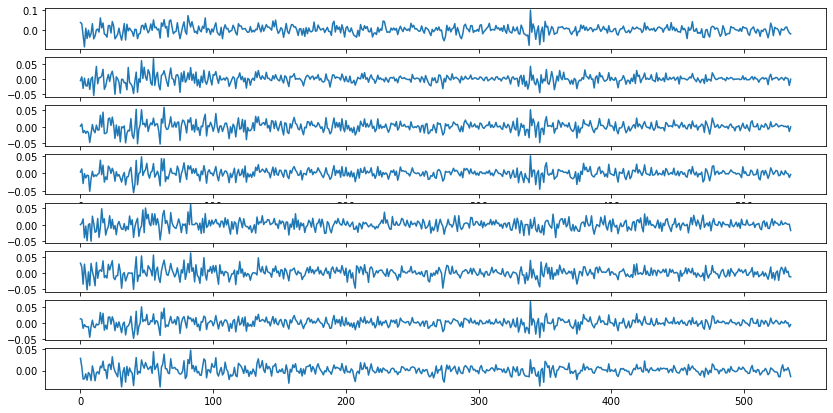

In [8]:
data_copy = data.drop(columns=["Unnamed: 0", "TL BASED"], index=[0])

multivariate_time_series = data_copy.to_numpy()
fig, axs =  plt.subplots(8, 1, figsize=(14,7))
for i in range(8):
    axs[i].plot(multivariate_time_series[:, i])
plt.show()

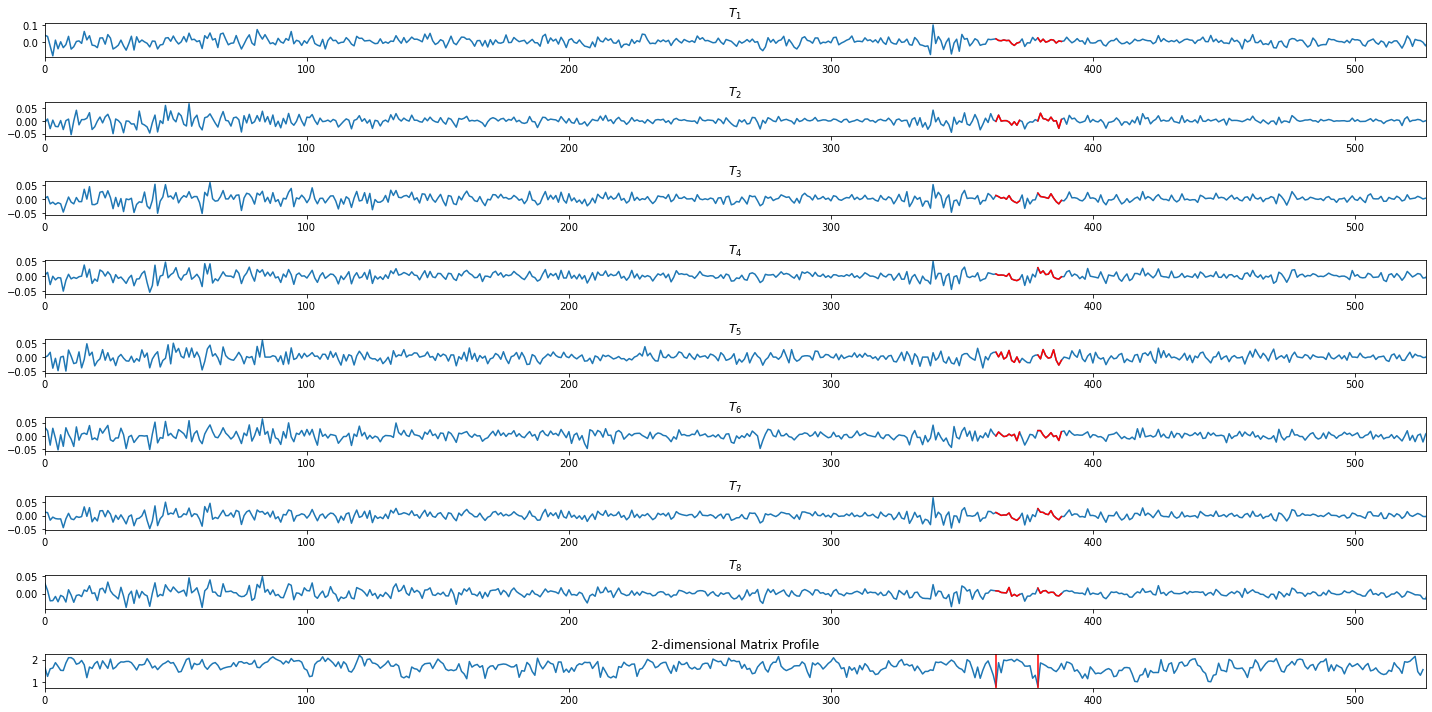

In [9]:
# plot the matrix profil for one dimension
sub_len = 10
mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, sub_len, return_dimension=False)
plot_motifs(mat_pro_approx, multivariate_time_series, sub_len, 2)

# Evolution of the RMSEs throughout the iterations

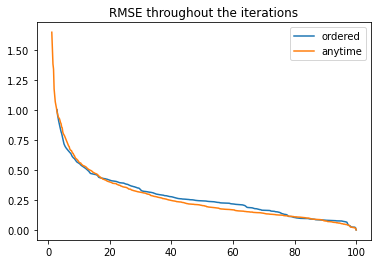

In [13]:
sub_len = 10
mat_pro_ref, pro_idx_ref = mstamp(multivariate_time_series.T, sub_len)
RMSEs = compute_mstamp_RMSEs(multivariate_time_series.T, sub_len, mat_pro_ref, random=False)
RMSEs_anytime = compute_mstamp_RMSEs(multivariate_time_series.T, sub_len, mat_pro_ref, random=True)

n = multivariate_time_series.shape[0]
perc_iters = np.linspace(1,100,n-sub_len+1)
max_val = max([RMSEs[RMSEs < np.inf].max(),
               RMSEs_anytime[RMSEs_anytime < np.inf].max()])
plt.figure()
plt.title("RMSE throughout the iterations")
plt.plot(perc_iters, RMSEs)
plt.plot(perc_iters, RMSEs_anytime)
plt.legend(["ordered", "anytime"])
plt.show()

# Running time depending on the subsequence length

100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


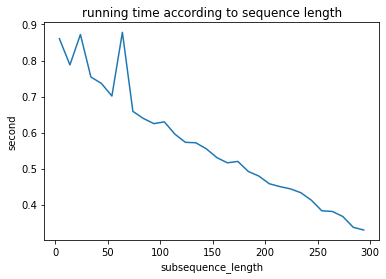

In [17]:
max_subsequence_length = 300
subsequence_length = 4 + np.arange(0, max_subsequence_length, 10)
sec = []
for sub in tqdm(subsequence_length):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, sub)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(subsequence_length, sec)
plt.title("running time as a function of sequence length")
plt.xlabel("subsequence_length")
plt.ylabel("second")
plt.show()

# Running time depending on the dimensionality

In [19]:
all_data = pd.read_csv("DJIA_30_Stock/all_stocks_2006-01-01_to_2018-01-01.csv")
names = list(set(all_data["Name"].tolist()))

length = 3019
dims = len(names)
final_data = np.zeros((dims, length))
lens = []
for k, name in enumerate(names):
    data = np.array(all_data[all_data["Name"] == name]["Open"].tolist())
    mask = np.isnan(data)
    data[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data[~mask])
    assert np.any(~np.isnan(data))
    lens.append(len(data))
    final_data[k] = data[:length].copy()

data = final_data


100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


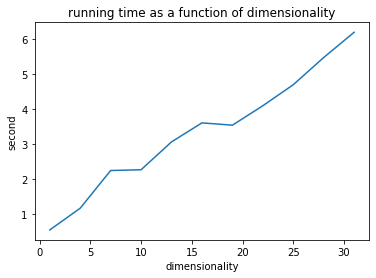

In [31]:
length = 1000
sub_len = 50
nb_dims_list = np.arange(1,32,3)
sec = []
for nb_dims in tqdm(nb_dims_list):
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(final_data[:nb_dims,:length], sub_len)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
plt.plot(nb_dims_list, sec)
plt.title("running time as a function of dimensionality")
plt.xlabel("dimensionality")
plt.ylabel("seconds")
plt.show()

# MDL-based method

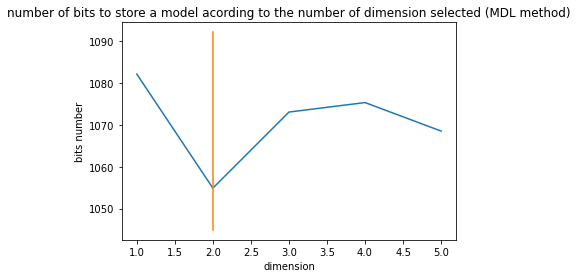

In [33]:
nb_dims = 5
length = 1000
sub_len = 50

mat_pro, pro_idx, profile = mstamp(final_data[:nb_dims,:length], sub_len, return_dimension=True)
bits = MDL(mat_pro, final_data[:nb_dims,:length].T, sub_len, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)

plt.plot(np.arange(nb_dims) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimension")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

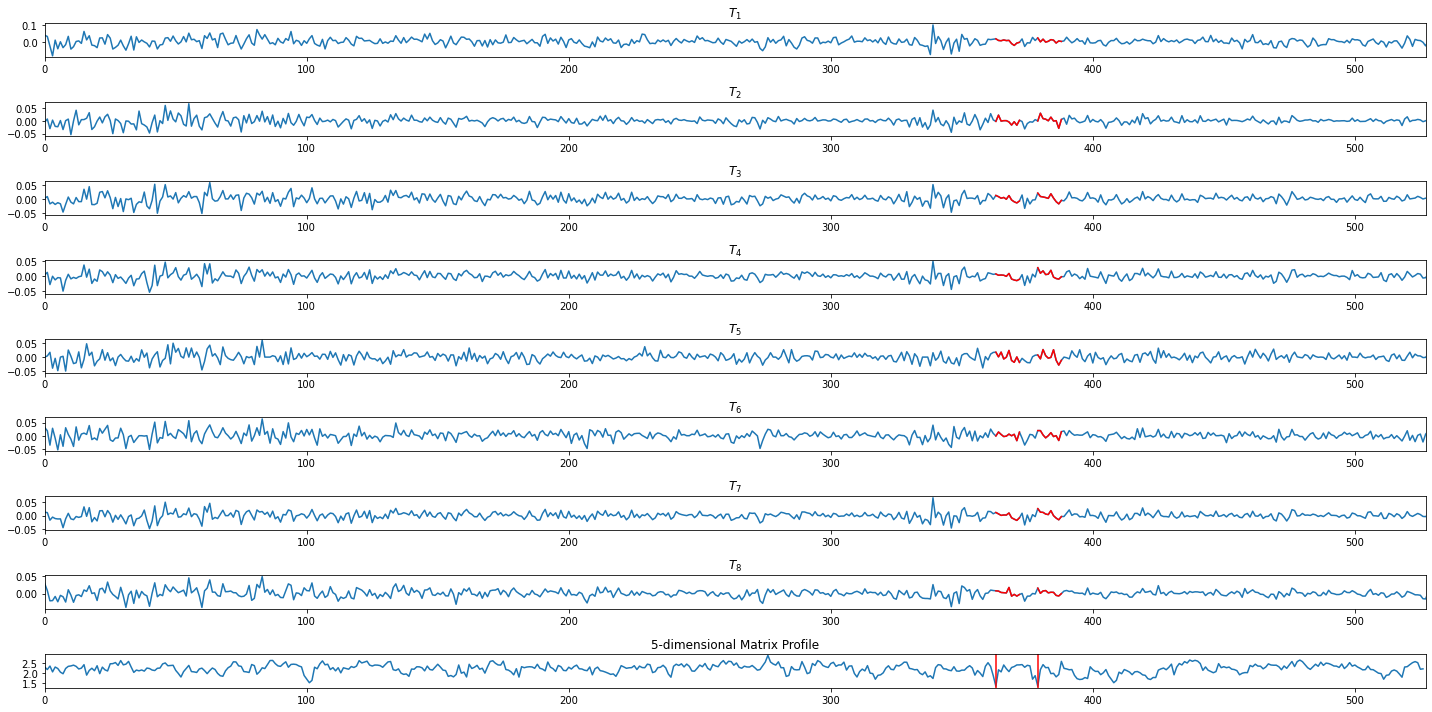

In [11]:
# plot the matrix profil for best dimension dimension

mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, 10, return_dimension=False)
plot_motifs(mat_pro_approx, multivariate_time_series, 10, argmin)

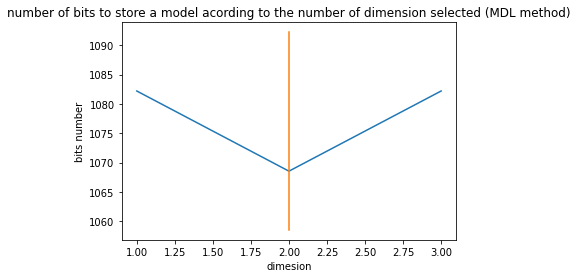

In [12]:
import scipy.io as sio

mat = sio.loadmat('toy_data.mat')
data = mat['data']
sub_len = mat['sub_len'][0][0]

mat_pro, pro_idx, profile = mstamp(data.T, sub_len, return_dimension=True)
bits = MDL(mat_pro, data, 50, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)
plt.plot(np.arange(3) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimension")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

In [ ]:
t_c = np.array([[1, 3, 4, 5, 4, 3, 6, 15, 14, 13, 12, 0, 2, 4, 2, 6, 10, 11, 9, 3]])
t_h = np.array([[1, 3, 3, 5, 4, 3, 6, 15, 14, 13, 12, 0, 2, 3, 2, 6, 4, 3, 1, 0]])
RDL(t_c, t_h, h=2)